This notebook demonstrates how to generate a matrix that quantifies cooccurence of words in a review. There are various free parameters you can play with, for instance you could count coocurence of bigrams instead of words, and I have some commented out code that gives you some hints at how this might be done. You also don't need to look at coocurrence in reviews. It may be more informative to look at words which coocurr within a certain proximity of one another, which you could do by computing n-grams of words and counting coocurrence of words within an n-gram of a particular length, the logic being that if words appear in the same review, but the review is very long, then the fact that two words cooccur in that review doesn't tell you very much about them. One could appear at the beginning while another could appear at the end of the review, where the reviewer is discussing a totally different aspect of the product, and the valence of that discussion could be good in one place and bad in another. So there's stuff to play with here, but for now it's a proof of concept that works on our json files, so it's a good start I think.

Given a coocurrence matrix we can compute a latent sematic space by computing the eigenvectors of the cooccurence matrix, which would be the latent dimensions of semantic space. Projecting any particular coocurrence vector (word) onto the eigenvectors gives you a vector representation of that word in the sematic space, and each element of that vector can serve as a feature in a classifier. The idea being to find a hyperplane within that semantic space that distinguishes words that distinguish 4.5+ star reviews from <4.5 star reviews. A naive bayes classifier can do this, but so can an SVM, and an SVM is likely going to more easily allow us to fit nonlinear classifiers using off the shelf tools.

In the (likely) event that good/bad topics aren't separated by a plane in this high dimensional space and are instead clustered in a pockmarked manner we could use SVMs with nonlinear kernels, like a radial basis function, to separate them (could do this with naive bayes too, but we'd likely need to apply the kernel functions and optimize them manually, since off the shelf naive bayes tools aren't likely to support them, and that would be a pain). An SVM with a radial basis function kernel spans an infinite set of functions, meaning it can fit an arbitrary classification function given enough training data, but it has biases and you can think of it as a kind of informal prior. What is it biased towards? My best understanding is that it's a kind of classification that resembles a smoothed nearest neighbor function, which would work well if our training data samples densely enough from the semantic space (probably does, at least from all relevant areas), and fits with this idea of there being clusters of good meaning and bad meaning words in the smantic space. Second order polynomial kernels are also worth looking at. I don't have any sort of intuitive grasp of what they do to the training space, but I've heard they're popular in natural language processing. I don't think they're as flexible as radial basis functions (i.e. I don't think they permit all classification boundaries).

In [145]:
import json

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk import bigrams

import numpy as np
import itertools

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB


In [285]:
this_list = []
for line in open('../data/Sports_and_Outdoors_Reviews_training.json', 'r'):
    this_list.append(json.loads(line))

In [287]:
# create a list, doc_list, with one review per elem
doc_list = []
rating = []
for i in range(0,len(this_list)):
    if this_list[i].get('reviewText'): #not all reviews have text
        rating.append(this_list[i].get('overall'))
        doc_list.append(this_list[i].get('reviewText'))

In [34]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [35]:
clean_text=preprocess_data(doc_list)

In [265]:
# copied this from some tutorial, and modified it. Computes bigrams
def generate_co_occurrence_matrix(corpus):
    # Create bigrams grams from all words in corpus
    #n_grams = []
    #for elem in corpus:
    #    n_grams.append(list(nltk.everygrams(elem,min_len=2,max_len=2)) )    
    
    # generate set of all unique words in corpus
    tup = tuple()
    for this_tup in corpus:
        tup = tup + this_tup
    vocab = set(tup)
    vocab = list(vocab)
    vocab_index = {word: i for i, word in enumerate(vocab)}
     
    m = np.zeros([len(vocab),len(corpus)]);
    for i,word1 in enumerate(vocab):
        for j,this_doc in enumerate(corpus):
            if word1 in this_doc:
                 m[i,j]=1

    co_occurrence_matrix = np.matrix(m)*np.matrix(np.transpose(m))

    wordFreq = np.sum(m,axis=1)
    frqtSrt = np.argsort(wordFreq)
    frqtSrt = frqtSrt[::-1]
    most_common = frqtSrt[0:985]
    
    co_occurrence_matrix = co_occurrence_matrix.take(most_common,axis=1)
    
    # normalize incidence
    #incidence = np.sum(m,axis=1)
    #a,b = np.shape(m)
    #from numpy import matlib as ml
    #incidence = ml.repmat(incidence,n=1,m=a)
    #co_occurrence_matrix = co_occurrence_matrix/(incidence*np.transpose(incidence))
    co_occurrence_matrix = np.log(1 + co_occurrence_matrix)
    from scipy import stats as sts
    co_occurrence_matrix = sts.zscore(sts.zscore(np.array(co_occurrence_matrix),axis=0),axis=1)

    vocab_tuple = tuple(vocab_index)
    basis_index = [];
    for i in range(0,len(most_common)):
        basis_index.append(vocab_tuple[most_common[i]])
    
    return co_occurrence_matrix, vocab_index, basis_index

In [266]:
clean_tuple = list(map(tuple, clean_text[0:2000]))
matrix, vocab_index, basis_index = generate_co_occurrence_matrix(clean_tuple)

In [276]:
# get highest frequency words (they look better when plotted)
idx = []
for i in range(0,len(matrix)):
    m = np.mean(np.abs(matrix[i]))
    if m > 0.89:
        idx.append(i) 

# I picked an arbitrary threshold above, so let's see how many words it picks.
len(idx)

15

In [279]:
vocab_tuple = tuple(vocab_index)
subvocab = [];
for i in range(0,len(idx)):
    subvocab.append(vocab_tuple[idx[i]])

[Text(0, 0, 'outta'),
 Text(0, 500, '26mm'),
 Text(0, 1000, 'plier'),
 Text(0, 1500, 'homework'),
 Text(0, 2000, 'verg'),
 Text(0, 2500, 'sex'),
 Text(0, 3000, 'surpris'),
 Text(0, 3500, 'contain'),
 Text(0, 4000, 'counter'),
 Text(0, 4500, 'hug')]

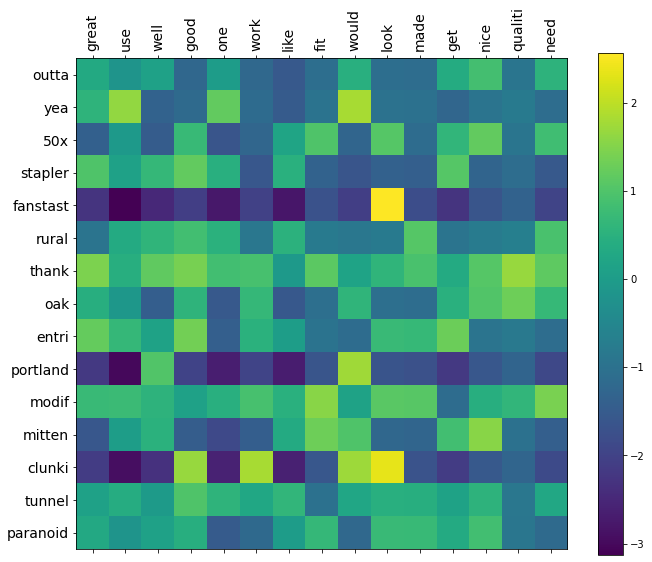

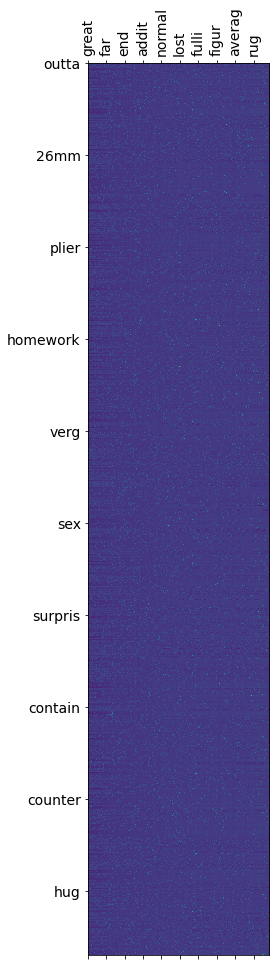

In [282]:
p = plt.matshow(matrix.take(list(range(0,len(idx))),axis=0).take(list(range(0,len(idx))),axis=1))

plt.gca().set_xticks(range(0,len(idx)))
plt.gca().set_xticklabels(list(basis_index[0:len(idx)]), rotation=90, fontsize=14)

plt.gca().set_yticks(range(0,len(idx)))
plt.gca().set_yticklabels(list(vocab_tuple[0:len(idx)]), fontsize=14)
f = plt.gcf()
f.colorbar(plt.gci())
f.set_size_inches(11,9)

p = plt.matshow(matrix)
plt.gca().set_xticks(range(0,len(basis_index),100))
plt.gca().set_xticklabels(list(basis_index[0:len(basis_index):100]), rotation=90, fontsize=14)

plt.gca().set_yticks(range(0,len(vocab_tuple),500))
plt.gca().set_yticklabels(list(vocab_tuple[0:len(vocab_tuple):500]), fontsize=14)